Data is used from Kaggle and aim of this project is to deploy a suitable model using django.
I added a pickle file in this version in order to deploy it using Django.

In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
file_path='../input/used-cars-price-prediction/train-data.csv'
train=pd.read_csv(file_path,index_col=0);
train.drop(["New_Price","Name","Location"],axis=1,inplace=True)


In [3]:
#data pre-processing

train["Mileage"]=train["Mileage"].str.replace('kmpl','')
train["Mileage"]=train["Mileage"].str.replace('km/kg','')#replacing text to blank
train["Mileage"]=pd.to_numeric(train["Mileage"],errors='coerce')#conversion to numeric from string
train["Power"]=train["Power"].str.replace('bhp','')
train["Power"]=pd.to_numeric(train["Power"],errors='coerce')
train["Engine"]=train["Engine"].str.replace('CC','')
train["Engine"]=pd.to_numeric(train["Engine"],errors='coerce')

In [4]:
#Missing values
train=train.dropna(axis=0)# to drop the rows with missing values
#train["Seats"]=train["Seats"].fillna(method='bfill',axis=0)# Fils value of preceding cell
#print(train["Name"].nunique(dropna=True))# Counting the number of unique cars in dataset
#print(train.query('Mileage<1').count())#counts the number of rows where Mileage is 0
#print(train.query('Engine=="nan"').count()) counts number of rows where specified column has nan value
train["Mileage"]=train["Mileage"].where(train["Mileage"]!=0,train["Mileage"].mean())#inserts mean of mileage at all places where Mileage is 0


In [5]:
train.columns

Index(['Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type',
       'Mileage', 'Engine', 'Power', 'Seats', 'Price'],
      dtype='object')

In [5]:
#dividing dataset for validation
y=train["Price"];
X=train.iloc[:,:-1];

#load test data
file_path2='../input/used-cars-price-prediction/test-data.csv'
test=pd.read_csv(file_path2,index_col=0);

In [6]:
#Handling Categorical values
from sklearn.preprocessing import OneHotEncoder

s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print(object_cols)

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X[object_cols]))
#OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X.index
OH_cols_train.columns=OH_encoder.get_feature_names(object_cols)#to copy the column label after encoding
#print(OH_cols_train.head(5))
#OH_cols_valid.index = val_X.index

# Remove categorical columns (will replace with one-hot encoding)
num_train = X.drop(object_cols, axis=1)
#num_X_valid = val_X.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_train = pd.concat([num_train, OH_cols_train], axis=1)
#print(OH_train.head(5))
#OH_X_val = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_train.columns

['Fuel_Type', 'Transmission', 'Owner_Type']


Index(['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats',
       'Fuel_Type_CNG', 'Fuel_Type_Diesel', 'Fuel_Type_LPG',
       'Fuel_Type_Petrol', 'Transmission_Automatic', 'Transmission_Manual',
       'Owner_Type_First', 'Owner_Type_Fourth & Above', 'Owner_Type_Second',
       'Owner_Type_Third'],
      dtype='object')

In [7]:
train_X, val_X, train_y, val_y = train_test_split(OH_train, y, random_state = 0)

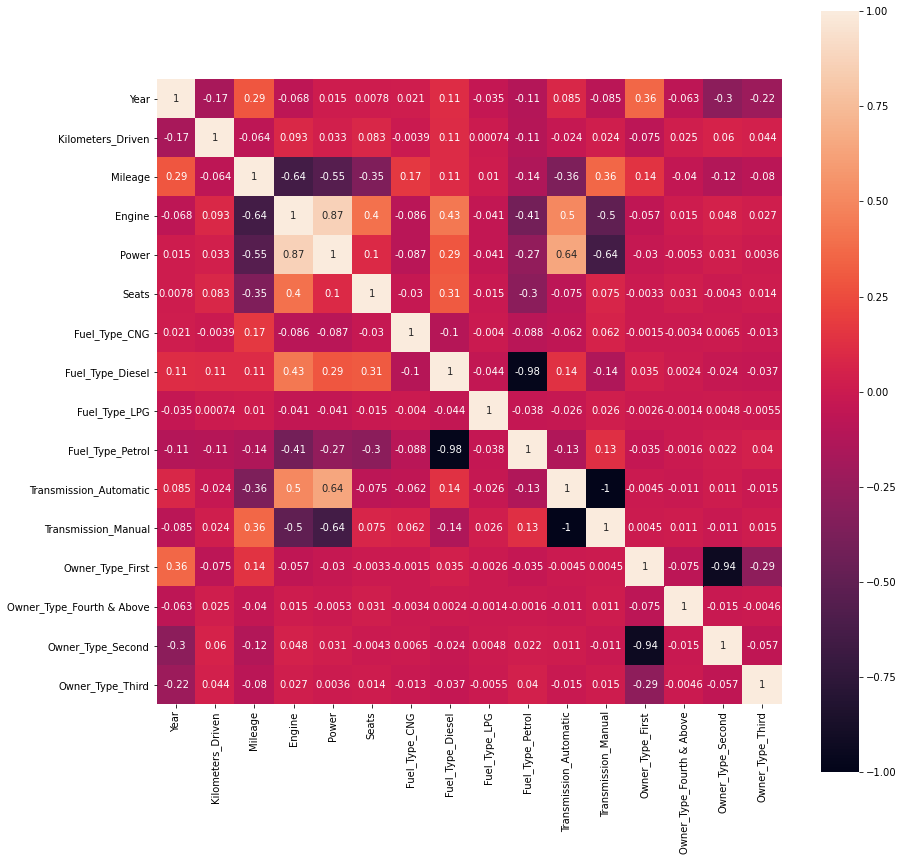

In [8]:
correlation=OH_train.corr()
plt.figure(figsize=(14,14))
sns.heatmap(data=correlation,square=True,annot=True)

In [32]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
decision_tree=DecisionTreeRegressor(random_state=0)
decision_tree.fit(train_X,train_y)
predict1=decision_tree.predict(val_X)
print("Mean Absolute Error:",mean_absolute_error(val_y,predict1))
print("Mean Squared Error:",mean_squared_error(val_y,predict1))
#print(decision_tree.score(predict1,val_y.reshape(1,-1)[0]))


Mean Absolute Error: 2.344131471389646
Mean Squared Error: 37.360568068801086


In [55]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
random_forest=RandomForestRegressor(random_state=1)
random_forest.fit(train_X,train_y)
predict2=random_forest.predict(val_X)
print("Mean Absolute Error:",mean_absolute_error(val_y,predict2))
print("Mean Squared Error:",mean_squared_error(val_y,predict2))

[[2.013e+03 4.067e+04 1.520e+01 1.968e+03 1.408e+02 5.000e+00 0.000e+00
  1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00 0.000e+00]]
[12.44129167]
Mean Absolute Error: 1.6850457647268715
Mean Squared Error: 13.418417479462944


In [34]:
#XG Boost Regressor
from xgboost import XGBRegressor
my_model = XGBRegressor()
my_model.fit(train_X,train_y)
predict3 = my_model.predict(val_X)
print("Mean Absolute Error:",mean_absolute_error(val_y,predict3))
print("Mean Squared Error:",mean_squared_error(val_y,predict3))

Mean Absolute Error: 1.6504869344270197
Mean Squared Error: 13.962802358723712


In [49]:
from sklearn.linear_model import Lasso
clf=Lasso(alpha=0.1)
clf.fit(train_X,train_y)
predict4=clf.predict(val_X)
print("Mean Absolute Error:",mean_absolute_error(val_y,predict4))
print("Mean Squared Error:",mean_squared_error(val_y,predict4))

Mean Absolute Error: 3.910095736748955
Mean Squared Error: 42.2668708270898


Random Forest works best so I will use its model

In [35]:
import pickle 
#from sklearn.externals import joblib
filename = 'Price_predict.pkl'
pickle.dump(random_forest,open(filename,"wb"))
